<a href="https://colab.research.google.com/github/tj-mas04/MedGen_Synthetic-Medical-Data/blob/main/WGAN256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions

In [2]:
# Example: Download a dataset
!kaggle datasets download -d nusratjahanpritha/fetal-mri -p /content/data --unzip

Dataset URL: https://www.kaggle.com/datasets/nusratjahanpritha/fetal-mri
License(s): unknown
100% 2.89G/2.89G [00:35<00:00, 31.8MB/s]
100% 2.89G/2.89G [00:35<00:00, 86.5MB/s]


In [3]:
# Install necessary libraries
!pip install torch torchvision numpy matplotlib tqdm scipy tensorboard

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import grad
from torchvision.utils import save_image
import os
import torchvision.datasets as datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [4]:
# Check GPU availability
if torch.cuda.is_available():
    print(f"Using device: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**2:.2f} MB")
else:
    print("CUDA not available, using CPU.")

# Ensure reproducibility
torch.manual_seed(42)

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: Tesla T4
Total GPU memory: 15095.06 MB
Using device: cuda


Total images loaded: 52899


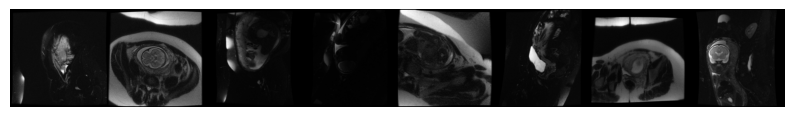

In [5]:
# Define dataset transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resizing for efficiency
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize images
])

# Load Dataset
dataset = torchvision.datasets.ImageFolder(root="/content/data", transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

print(f"Total images loaded: {len(dataset)}")

# Display sample images
def show_sample_images():
    real_batch = next(iter(dataloader))
    images, _ = real_batch
    grid = torchvision.utils.make_grid(images[:16], normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.show()

show_sample_images()


In [6]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.z_dim = z_dim

        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),  # Output: 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # Output: 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # Output: 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # Output: 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),  # Output: 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),  # Output: 128x128
            nn.BatchNorm2d(16),
            nn.ReLU(True),

            nn.ConvTranspose2d(16, 3, 4, 2, 1, bias=False),  # Output: 256x256
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# Instantiate Generator
z_dim = 100
G = Generator(z_dim).to(device)


In [7]:
import torch.nn.utils as utils

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            utils.spectral_norm(nn.Conv2d(3, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),

            utils.spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            utils.spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            utils.spectral_norm(nn.Conv2d(256, 512, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        )

    def forward(self, img):
        return self.model(img).view(-1)

D = Discriminator().to(device)


In [8]:
# Gradient Penalty Calculation
def compute_gradient_penalty(D, real_samples, fake_samples, device):
    batch_size, C, H, W = real_samples.shape
    alpha = torch.rand(batch_size, 1, 1, 1, device=device).expand_as(real_samples)

    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)

    fake = torch.ones_like(d_interpolates, device=device)

    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty



In [ ]:
import torch
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# Hyperparameters
z_dim = 100
epochs = 500
batch_size = 8
lambda_gp = 10
critic_iterations = 5
learning_rate = 0.0001

# Optimizers
optimizer_G = optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.9))

def save_and_display(epoch, gen_imgs):
    """Saves model, optimizer states, and generated images every 10 epochs."""
    # Save generated images
    image_path = f"generated_images/epoch_{epoch+1}.png"
    save_image(gen_imgs, image_path, normalize=True)

    # Display images
    grid = torchvision.utils.make_grid(gen_imgs[:16], normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.show()

    # Save model and optimizer states
    model_path = f"saved_models/epoch_{epoch+1}.pth"
    torch.save({
        'epoch': epoch + 1,
        'generator_state_dict': G.state_dict(),
        'discriminator_state_dict': D.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'loss_G': loss_G.item(),
        'loss_D': loss_D.item(),
    }, model_path)

    print(f"✅ Model and optimizer saved at epoch {epoch+1}")

# Training Loop
for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        z = torch.randn(real_imgs.shape[0], z_dim, 1, 1, device=device)
        fake_imgs = G(z).detach()
        real_loss = D(real_imgs).mean()
        fake_loss = D(fake_imgs).mean()
        gradient_penalty = compute_gradient_penalty(D, real_imgs, fake_imgs, device)
        loss_D = fake_loss - real_loss + lambda_gp * gradient_penalty
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        if i % critic_iterations == 0:
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, z_dim, 1, 1, device=device)
            gen_imgs = G(z)
            loss_G = -D(gen_imgs).mean()
            loss_G.backward()
            optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

    # Save and Display Every 10 Epochs
    if (epoch + 1) % 10 == 0:
        save_and_display(epoch, gen_imgs)